# Homework 4

### Cameron Bale

## Costa Rican Household Poverty Level Prediction

***

This homework will be split into 6 parts:
1. Initial Model
2. Data Cleaning and Exploration
3. Feature Engineering
4. Modeling
5. Tuning Hyperparameters
6. Generating Predictions

* My goal is to accurately predict which households are most qualified to receive aid using this data from Costa Rica. This model should be generalizable so that it can be used to predict household aid qualifications in different locations. I'll leverage what I've learned in my Machine Learning class at Brigham Young University, consulting with Conner Leavitt, and referencing notebooks created by Tyler Folkman. I'll provide links to all notebooks that were referenced for this project below.

* To start this project I'll begin by making an initial model to set a benchmark. Then, I'll explore and clean the data, looking for which variables are most closely related to being qualified for aid. I'll do some feature engineering to try and create more variables that are highly predictive and will hopefully help my models more accurately classify households. Then, I'll start implementing a wide variety of models to see which ones produce the best initial results. I'll take the top 2, and tune their hyperparameters to narrow in on the best model. Once that's done, I'll pick the model which most accurately predicts household poverty levels for the training data, and use it to predict poverty levels for households in the test data.

## Part 1: Initial Model

First I'll import packages and read in the data.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in data
train_data = pd.read_csv("C:/Users/camer/Desktop/Machine_Learning/cr_train.csv")

In [3]:
# view data to make sure it read in correctly
train_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
# create 'target_initial' which is what I'm trying to predict using this initial model and drop 'target' from 'train_data'
target_initial = train_data['Target']
train_data_initial = train_data.drop('Target', axis = 1)

In [5]:
# create a vector 'missing_vars' which contains all variables that have 
missing_vars = train_data_initial.columns[train_data_initial.isna().any()].tolist()

In [6]:
# drop the variables with missing values from the data
train_data_initial = train_data_initial.drop(missing_vars, axis = 1)

In [7]:
# create dummy variables
train_data_init_dums = pd.get_dummies(train_data_initial)

In [8]:
# import to perform logistic regression and accuracy score metric
from sklearn import linear_model
from sklearn.metrics import accuracy_score

logreg = linear_model.LogisticRegression()
logreg.fit(train_data_init_dums, target_initial)

print("Model Accuracy: {}".format(accuracy_score(target_initial, logreg.predict(train_data_init_dums))))

Model Accuracy: 0.8880401799727948


This initial model didn't perform too poorly, it was about 89% accurate. But, I bet I can do better. Now I'll move on to part 2 and perform data exploration and cleaning so I have a better understanding of what this data contains.

***

## Part 2: Data Cleaning and Exploration

I'll start by looking at the 'Target' variable, which in this case should be an integer from 1 to 4 classifying a household as

1: extreme poverty

2: moderate poverty

3: vulnerable households

4: non-vulnerable households

In [9]:
train_data.Target.describe()

count    9557.000000
mean        3.302292
std         1.009565
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Target, dtype: float64

This looks good, nothing crazy going on. Our max is 4, our min is 1, and the average is 3.3. So, most houses are probably classified as 3 or 4.

In [10]:
class_counts = pd.value_counts(train_data.Target.values, sort = False)
class_counts

1     755
2    1597
3    1209
4    5996
dtype: int64

This is interesting: most of the houses in our data are classified as 4's. If you created a model that only predicted 4, you would actually be fairly precise.

([<matplotlib.axis.XTick at 0x1f1c21b74a8>,
 <a list of 4 Text xticklabel objects>)

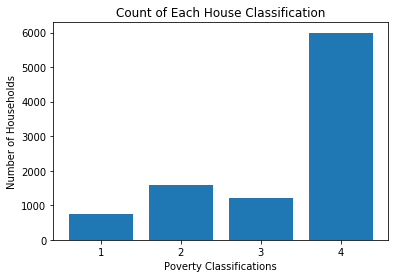

In [11]:
plt.bar(class_counts.index, class_counts)
plt.title('Count of Each House Classification')
plt.xlabel('Poverty Classifications')
plt.ylabel('Number of Households')
plt.xticks([1, 2, 3, 4])

In [12]:
target_initial.value_counts(normalize = True) * 100

4    62.739353
2    16.710265
3    12.650413
1     7.899969
Name: Target, dtype: float64

In the first model that I ran, I got 88% accuracy. This is pretty high, and a lot of it is probably due to the fact that the data is pretty imbalanced. If you were to just predict every house as a 4, your model would be 62.7% accurate. My model is only about a 26% improvement from just guessing all houses to be 4.

In [13]:
train_data.columns.values

array(['Id', 'v2a1', 'hacdor', 'rooms', 'hacapo', 'v14a', 'refrig',
       'v18q', 'v18q1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3',
       'r4t1', 'r4t2', 'r4t3', 'tamhog', 'tamviv', 'escolari', 'rez_esc',
       'hhsize', 'paredblolad', 'paredzocalo', 'paredpreb', 'pareddes',
       'paredmad', 'paredzinc', 'paredfibras', 'paredother', 'pisomoscer',
       'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene',
       'pisomadera', 'techozinc', 'techoentrepiso', 'techocane',
       'techootro', 'cielorazo', 'abastaguadentro', 'abastaguafuera',
       'abastaguano', 'public', 'planpri', 'noelec', 'coopele',
       'sanitario1', 'sanitario2', 'sanitario3', 'sanitario5',
       'sanitario6', 'energcocinar1', 'energcocinar2', 'energcocinar3',
       'energcocinar4', 'elimbasu1', 'elimbasu2', 'elimbasu3',
       'elimbasu4', 'elimbasu5', 'elimbasu6', 'epared1', 'epared2',
       'epared3', 'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2',
       'eviv3', 'dis', 'male', 'female', '

There are a total of 142 variables in this data, so I'll see if I can narrow down the selection to the variables that really matter for predicting household poverty levels.

The Id variable is uneccessary since it just identifies which row it is, so I'll drop that.

In [14]:
train_data = train_data.drop('Id', axis = 1)

Now I'll make a heatmap to see which variables are most correlated with poverty level. I'll also display the variables that have missing values. I want to see the correlation that variables with missing values have with poverty level.

Text(0.5,1,'Variables Correlated With Poverty Level')

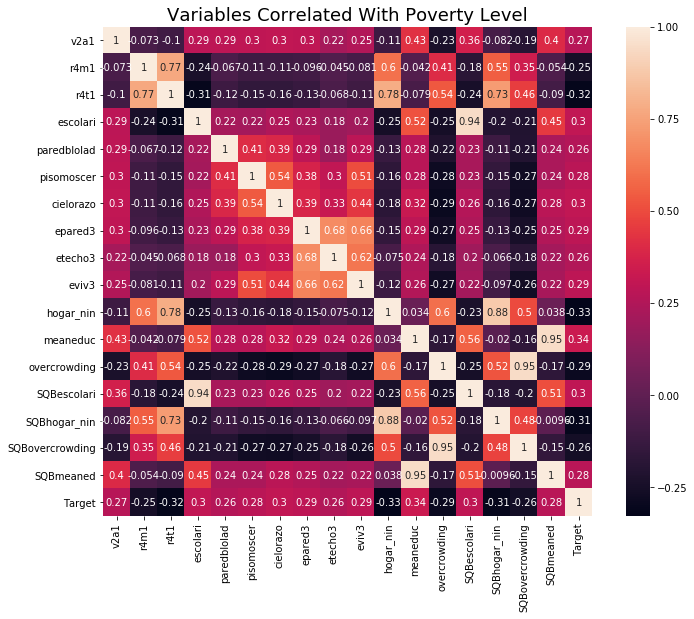

In [15]:
# create heatmap showing variables correlated with poverty at an absolute value above 0.25
corr_train = train_data.corr()
highest_corr = corr_train.index[abs(corr_train["Target"])>0.25]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train_data[highest_corr].corr(), square = True, annot = True)
plt.title('Variables Correlated With Poverty Level', fontsize=18)

In [16]:
# view the variables that have missing values
train_data.isnull().sum().sort_values(ascending=False).head(10)

rez_esc           7928
v18q1             7342
v2a1              6860
meaneduc             5
SQBmeaned            5
etecho1              0
sanitario3           0
techoentrepiso       0
techocane            0
techootro            0
dtype: int64

In [17]:
corr_values = train_data.corrwith(target_initial).sort_values(ascending = False)

In [18]:
corr_values['rez_esc']

-0.09935727182117661

In [19]:
print(corr_values['v18q1'])
corr_values['v18q']

-0.007334410386887168


0.23886372402035708

There are 5 variables with missing values. Three of them, 'rez_esc', 'v18q1', and 'v2a1', are mostly filled with NA while 'meaneduc' and 'SQBmeaned' only have 5 missing values. I want to compare the variables with missing values to the variables that are highly correlated with our target variable. If variables have a lot of missing values and are weakly correlated with our target, I will consider dropping them from the analysis.

The variable with the most missing values, 'rez_esc', does not appear to be very highly correlated with our target. 'rez_esc' represents the number of years an individual is behind in school. Education is, in general, correlated with poverty, but there are other variables in the data such as 'meaneduc', which represents the average years of education for adults, and 'SQBmeaned' which is the square of the average number of years of education of adults. These education variables are more highly correlated with our target than 'rez_esc' which only has a correlation with our target of about -.10, but I feel like -0.1 is not small enough to justify dropping the variable from the data at this point.

For the 'v18q1' variable, which represents the number of tablets a household owns, the correlation with poverty level is very small. However, the variable 'v18q', which indicates whether a person owns a tablet, is fairly correlated with poverty level. I'll assume that if there is a missing value in 'v18q1' the household doesn't have any tablets.

In [20]:
train_data['v18q1'] = train_data['v18q1'].fillna(0)

As far as the other variables with missing values, I'll just fill in what seems most appropriate: they are continuous variables so I'll fill missing values with the mean of that variable.

In [21]:
# Create missing rent payment column
train_data['v2a1-missing'] = train_data['v2a1'].isnull()
train_data = train_data.fillna(train_data.mean())

A key step in machine learning is coding all your categorical variables as dummies. I want to make sure my categorical variables should be categorical variables.

In [22]:
train_data.select_dtypes('object').head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


'idhogar' is a unique identifier for each household. It won't have any predictive power so I'll drop it. Dependency is supposed to represent the number of dependents that are living in a household: people under 18 or over 65. This shouldn't be coded as yes or no, so I'll replace the 'no' values with 0 and the 'yes' values with the average number of dependents in households. 'edjefe' and 'edjefa' are supposed to represent the number of years of education of male and female heads of household, so I'll replace no values with 0.

In [23]:
train_data = train_data.drop('idhogar', axis = 1)

In [24]:
dependents = train_data.loc[(train_data['dependency'] != 'yes') & (train_data['dependency'] != 'no')]['dependency']
dependents = pd.to_numeric(dependents)
dep_mean = np.mean(dependents)
print(dep_mean)

1.5653709487201788


In [25]:
train_data['dependency'].replace('no', 0, inplace=True)
train_data['dependency'].replace('yes', dep_mean, inplace=True)

In [26]:
train_data['edjefe'].replace('no', 0, inplace=True)
train_data['edjefa'].replace('no', 0, inplace=True)
train_data['edjefe'].replace('yes', 1, inplace=True)
train_data['edjefa'].replace('yes', 1, inplace=True)

In [27]:
train_data[['dependency', 'edjefe', 'edjefa']] = train_data[['dependency', 'edjefe', 'edjefa']].apply(pd.to_numeric)

I don't think there are any variables that are currently classified as numeric that should be categorical.

Now that missing values have been handled, I'll work on feature engineering.

## Part 3: Feature Engineering

In [28]:
# Difference between people living in house and household size
train_data['hhsize-diff'] = train_data['tamviv'] - train_data['hhsize']

elec = []

# Assign values
for i, row in train_data.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)

In [29]:
# Record the new variable and missing flag
train_data['elec'] = elec
train_data['elec-missing'] = train_data['elec'].isnull()

In [30]:
train_data.elec.value_counts()

2.0    8459
1.0    1059
0.0      21
3.0       3
Name: elec, dtype: int64

In [31]:
train_data['elec'] = train_data.elec.fillna(2)

In [32]:
# Wall ordinal variable
train_data['walls'] = np.argmax(np.array(train_data[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

train_data = train_data.drop(columns = ['epared1', 'epared2', 'epared3'])

# Roof ordinal variable
train_data['roof'] = np.argmax(np.array(train_data[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
train_data = train_data.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
train_data['floor'] = np.argmax(np.array(train_data[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
train_data = train_data.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

# Create new feature
train_data['walls+roof+floor'] = train_data['walls'] + train_data['roof'] + train_data['floor']

# No toilet, no electricity, no floor, no water service, no ceiling
train_data['warning'] = 1 * (train_data['sanitario1'] + 
                         (train_data['elec'] == 0) + 
                         train_data['pisonotiene'] + 
                         train_data['abastaguano'] + 
                         (train_data['cielorazo'] == 0))

# Owns a refrigerator, computer, tablet, and television
train_data['bonus'] = 1 * (train_data['refrig'] + 
                      train_data['computer'] + 
                      (train_data['v18q1'] > 0) + 
                      train_data['television'])

# Per capita features
train_data['phones-per-capita'] = train_data['qmobilephone'] / train_data['tamviv']
train_data['tablets-per-capita'] = train_data['v18q1'] / train_data['tamviv']
train_data['rooms-per-capita'] = train_data['rooms'] / train_data['tamviv']
train_data['rent-per-capita'] = train_data['v2a1'] / train_data['tamviv']

# Create one feature from the `instlevel` columns
train_data['inst'] = np.argmax(np.array(train_data[[c for c in train_data if c.startswith('instl')]]), axis = 1)
train_data = train_data.drop(columns = [c for c in train_data if c.startswith('instlevel')])

train_data['tech'] = train_data['v18q'] + train_data['mobilephone']

Text(0.5,1,'Variables Correlated With Poverty Level')

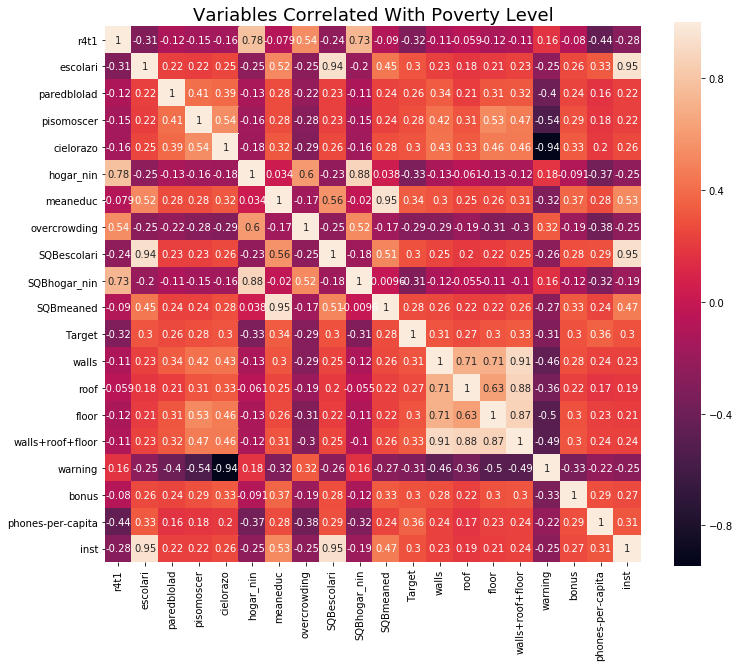

In [33]:
# create heatmap showing variables correlated with poverty at an absolute value above 0.25
corr_train = train_data.corr()
highest_corr = corr_train.index[abs(corr_train["Target"])>0.26]
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(train_data[highest_corr].corr(), square = True, annot = True)
plt.title('Variables Correlated With Poverty Level', fontsize=18)

This is good: we have more variables now that are more highly correlated with poverty than the original variables were.

## Part 4: Modeling

Now I'll run the data through a bunch of models to see which ones perform the best initially, then move on to tuning hyperparameters for the best performing models. I need to separate my target variable from the train data first.

In [34]:
target = train_data.Target
train_data = train_data.drop('Target', axis = 1)

I'll start with K-nearest neighbors.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(train_data, target) 
k_predictions = neigh.predict(train_data)
print("Model Accuracy: {}".format(accuracy_score(target, k_predictions)))

Model Accuracy: 0.7349586690384011


Next, I'll use logistic regression. Hopefully there's an improvement over my baseline model.

In [36]:
logreg.fit(train_data, target)
log_predictions = logreg.predict(train_data)
print("Model Accuracy: {}".format(accuracy_score(target, log_predictions)))

Model Accuracy: 0.6547033587946008


Next, I'll try Naive Bayes.

In [37]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
bayes_pred = gnb.fit(train_data, target).predict(train_data)
print("Model Accuracy: {}".format(accuracy_score(target, bayes_pred)))

Model Accuracy: 0.5570785811447106


Next, I'll try SVM.

In [38]:
from sklearn.svm import SVC
machine = SVC()
machine.fit(train_data, target) 
machine_predictions = machine.predict(train_data)
print("Model Accuracy: {}".format(accuracy_score(target, machine_predictions)))

Model Accuracy: 0.9699696557497123


Next, I'll try a random forest.

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
rf = RandomForestClassifier()
rf.fit(train_data, target)
rf_predictions = rf.predict(train_data)
print("Model Accuracy: {}".format(accuracy_score(target, rf_predictions)))
print("Test Classification Report:")
print(classification_report(target, rf_predictions))

Model Accuracy: 0.9986397405043423
Test Classification Report:
             precision    recall  f1-score   support

          1       1.00      0.99      1.00       755
          2       1.00      1.00      1.00      1597
          3       1.00      1.00      1.00      1209
          4       1.00      1.00      1.00      5996

avg / total       1.00      1.00      1.00      9557



Well, that produced some interesting results. Logistic regression performed much worse than it did in the initial model. It was barely better than a model that just predicts 4 for every house. Naive Bayes performed horribly, worse than just predicting 4. K-nearest neighbors was not great, but almost 10 percent better than just prediction 4. SVM and Random Forest produced really good results, with SVM being 97% accurate, and random forest being 100% accurate. However, the Random Forest algorithm is probably overfitting.

## Part 5: Tuning Hyperparameters

SVM and Random Forest were the models that performed the best. I'll work on tuning hyperparameters for SVM to see if it can be improved. The Random Forest algorithm already perfectly predicted the target variable.

I couldn't include hyperparameter selection due to computing constraints: my computer won't run gridsearch CV in any reasonable amount of time. If I could run it, this is what I would run:

First to get the best hyperparameter values for the SVM model:

In [40]:
#from sklearn.model_selection import train_test_split, GridSearchCV

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#machine = SVC()
#gridsearch = GridSearchCV(machine, {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 
                                #'degree': [1, 2, 3], 'gamma': [1, 5, 11]}, scoring='accuracy')
#gridsearch.fit(X_train, y_train)
#print("Best Params: {}".format(gridsearch.best_params_))
#print("Test Accuracy: {}".format(accuracy_score(y_test, gridsearch.predict(X_test))))

Next, to get the best parameter values for the random forest:

In [41]:
#n_estimators = [1000, 2500, 5000]
#max_depth = [1, 3, 5, 10]
#class_weights = ['balanced', None]
#best_f1 = 0

#for est in n_estimators:
    #for depth in max_depth:
        #for wgt in class_weights:
            #print(est, depth, wgt)
            #clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            #clf.fit(X_train, y_train)
            #f1 = f1_score(y_train, np.argmax(clf.oob_decision_function_ , 1))
            #if f1 > best_f1:
                #best_f1 = f1
                #best_params = (est, depth, wgt)

In [42]:
#print("Best OOB F1: {}".format(best_f1))
#print("Best params: {}".format(best_params))

In [43]:
#clf = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
#clf.fit(X_train, y_train)
#test_predictions = clf.predict(X_test)
#print("Test Classification Report:")
#print(classification_report(y_test, test_predictions))

## Evaluating This Assignment

The best f1 score I was able to achieve was using the random forest model listed above, and the f1 score was 1.

## Part 6: Generating Predictions

Now I'll perform the data cleaning and feature engineering on the test data.

In [44]:
# read in data
test_data = pd.read_csv("C:/Users/camer/Desktop/Machine_Learning/cr_test.csv")

In [45]:
test_data = test_data.drop('Id', axis = 1)

In [46]:
test_data['v18q1'] = test_data['v18q1'].fillna(0)

In [47]:
# Create missing rent payment column
test_data['v2a1-missing'] = test_data['v2a1'].isnull()
test_data = test_data.fillna(test_data.mean())

In [48]:
test_id = test_data.idhogar
test_data = test_data.drop('idhogar', axis = 1)

In [49]:
dependents = test_data.loc[(test_data['dependency'] != 'yes') & (test_data['dependency'] != 'no')]['dependency']
dependents = pd.to_numeric(dependents)
dep_mean = np.mean(dependents)

In [50]:
test_data['dependency'].replace('no', 0, inplace=True)
test_data['dependency'].replace('yes', dep_mean, inplace=True)

In [51]:
test_data['edjefe'].replace('no', 0, inplace=True)
test_data['edjefa'].replace('no', 0, inplace=True)
test_data['edjefe'].replace('yes', 1, inplace=True)
test_data['edjefa'].replace('yes', 1, inplace=True)

In [52]:
test_data[['dependency', 'edjefe', 'edjefa']] = test_data[['dependency', 'edjefe', 'edjefa']].apply(pd.to_numeric)

In [53]:
# Difference between people living in house and household size
test_data['hhsize-diff'] = test_data['tamviv'] - test_data['hhsize']

elec = []

# Assign values
for i, row in test_data.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)

In [54]:
# Record the new variable and missing flag
test_data['elec'] = elec
test_data['elec-missing'] = test_data['elec'].isnull()

In [55]:
test_data['elec'] = test_data.elec.fillna(2)

In [56]:
# Wall ordinal variable
test_data['walls'] = np.argmax(np.array(test_data[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

test_data = test_data.drop(columns = ['epared1', 'epared2', 'epared3'])

# Roof ordinal variable
test_data['roof'] = np.argmax(np.array(test_data[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
test_data = test_data.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
test_data['floor'] = np.argmax(np.array(test_data[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
test_data = test_data.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

# Create new feature
test_data['walls+roof+floor'] = test_data['walls'] + test_data['roof'] + test_data['floor']

# No toilet, no electricity, no floor, no water service, no ceiling
test_data['warning'] = 1 * (test_data['sanitario1'] + 
                         (test_data['elec'] == 0) + 
                         test_data['pisonotiene'] + 
                         test_data['abastaguano'] + 
                         (test_data['cielorazo'] == 0))

# Owns a refrigerator, computer, tablet, and television
test_data['bonus'] = 1 * (test_data['refrig'] + 
                      test_data['computer'] + 
                      (test_data['v18q1'] > 0) + 
                      test_data['television'])

# Per capita features
test_data['phones-per-capita'] = test_data['qmobilephone'] / test_data['tamviv']
test_data['tablets-per-capita'] = test_data['v18q1'] / test_data['tamviv']
test_data['rooms-per-capita'] = test_data['rooms'] / test_data['tamviv']
test_data['rent-per-capita'] = test_data['v2a1'] / test_data['tamviv']

# Create one feature from the `instlevel` columns
test_data['inst'] = np.argmax(np.array(test_data[[c for c in test_data if c.startswith('instl')]]), axis = 1)
test_data = test_data.drop(columns = [c for c in test_data if c.startswith('instlevel')])

test_data['tech'] = test_data['v18q'] + test_data['mobilephone']

Now the test data is ready, I'll make my final predictions.

In [57]:
rf_final_predictions = rf.predict(test_data)

Referenced Notebooks:

https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_5_Logistic_Regression_and_Evaluation.ipynb

https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_6_K_Nearest_Neighbors.ipynb

https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_7_Naive_Bayes.ipynb

https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_8_SVM.ipynb

https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_10_Random_Forest.ipynb

https://www.kaggle.com/willkoehrsen/featuretools-for-good/notebook
